# Partial least squares 

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from sklearn.metrics import f1_score

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [253]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
data_path = prefix + 'representation_learning_variability/paper-individuality/clustering/'
# states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')

filename = str(data_path + 'all_sequences_09-29-2025')
# filename = str(data_path + 'all_sequences_02-16-2026')
all_sequences = pd.read_parquet(filename)


# metadata = pd.read_parquet(prefix + 'representation_learning_variability/paper-individuality/mixed_models/metadata_13-01-2026')
metadata = pd.read_parquet(prefix + 'representation_learning_variability/paper-individuality/mixed_models/metadata_01-11-2026')

In [90]:
data_path = prefix + 'representation_learning_variability/paper-individuality/clustering/'
# cluster_df = pd.read_parquet(data_path+'5_cluster_per_mice_pop_norm_3Feb2026')
cluster_df = pd.read_parquet(data_path+'5_cluster_per_mice_lab_norm_30Jan2026')
cluster_df = pd.read_parquet(data_path+'5_mouse_cluster_coef')
cluster_df = pd.read_parquet(data_path+'5_mouse_cluster_coef')
# cluster_df = pd.read_parquet(data_path+'5_cluster_per_mice_no_norm_4Feb2026')

cluster_df = cluster_df.rename(columns={'cluster':'mouse_cluster'})


In [91]:
data_path = prefix + 'representation_learning_variability/paper-individuality/learning_prediction/'
training_time = pd.read_parquet(data_path+'training_time_23-09-2025')

In [254]:
## Get sequences per trial epoch
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()

## Get sequences per trial

In [352]:
all_sequences['session'] = all_sequences['sample'].str[:36]
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

In [256]:
session_count = design_df[['mouse_name', 'session']].drop_duplicates().groupby(['mouse_name'])['session'].count().reset_index()
multi_sess_mice = session_count.loc[session_count['session']>2, 'mouse_name']
design_df = design_df.loc[design_df['mouse_name'].isin(multi_sess_mice)]

In [353]:
design_df = design_df.merge(cluster_df[['mouse_name', 'mouse_cluster']], on='mouse_name')

## Separate states per variable (one-hot encoding)

In [354]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
# use_sequences = replace_func(use_sequences)

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

## Average per session

In [355]:
session_syllables = pd.DataFrame(binarized)
session_syllables['session'] = design_df['session'].copy()
session_syllables = session_syllables.groupby('session')[np.arange(0, np.shape(binarized)[1], 1)].mean()

In [356]:
mapping = design_df[['mouse_name', 'session', 'mouse_cluster']].drop_duplicates()

Text(0, 0.5, 'Sessions')

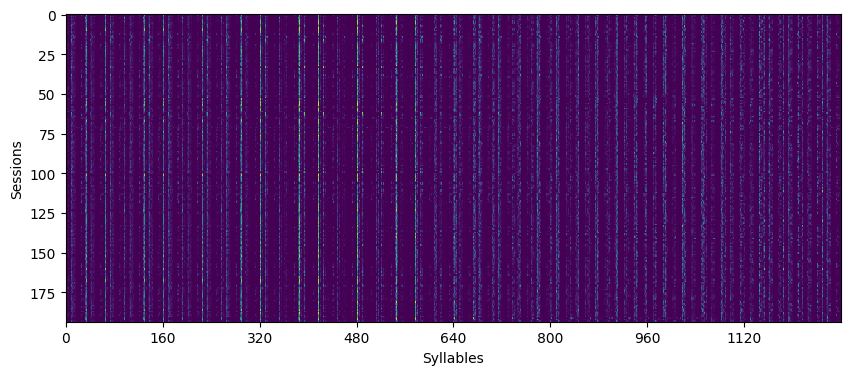

In [357]:
plt.figure(figsize=(10, 4))
plt.imshow(np.array(session_syllables), aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(binarized)[1], 160), np.arange(0, np.shape(binarized)[1], 160))
plt.xlabel('Syllables')
plt.ylabel('Sessions')

Text(0.5, 1.0, 'Explained Variance by PCA')

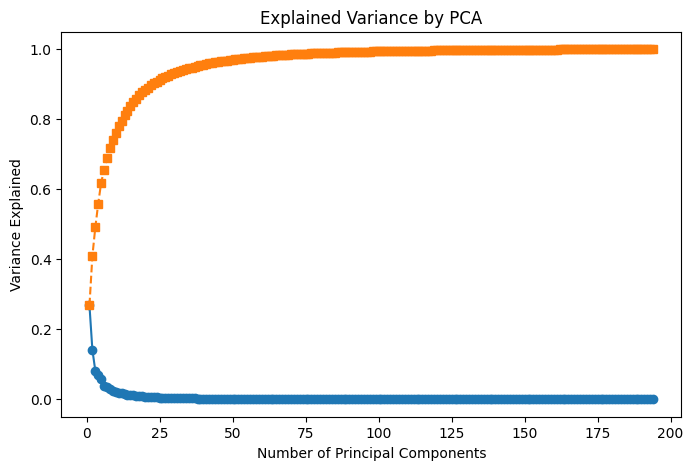

In [358]:
# PCA
n_components = np.shape(np.array(session_syllables))[0]
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
scaler = StandardScaler()
# standardized_X = scaler.fit_transform(np.array(session_syllables))
# X_pca = pca.fit_transform(standardized_X)
X_pca = pca.fit_transform(np.array(session_syllables))

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")

In [359]:
min_components = np.where(cumulative_variance>0.95)[0][0]
print(min_components)
# min_components = 20

37


In [360]:
mat = np.array(X_pca[:, :min_components])
# mat = np.array(session_syllables)

In [361]:
syllables_df = pd.DataFrame(mat)
syllables_df['mouse_name'] = session_syllables.reset_index().merge(mapping, on=['session'])['mouse_name']
syllables_df = syllables_df.merge(training_time, on='mouse_name')

In [362]:
from sklearn.cross_decomposition import PLSRegression

# X: n_samples x n_features
# y: n_samples (continuous)

X = np.array(mat)
y = np.array(syllables_df['training_time'])
# np.random.shuffle(y)

# # Scale X (important!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled = X.copy()

pls = PLSRegression(n_components=10)
pls.fit(X_scaled, y)

X_pls = pls.transform(X_scaled)  # projected data

X_scores = pls.x_scores_
X_weights = pls.x_weights_
X_loadings = pls.x_loadings_

PearsonRResult(statistic=0.7396362722086628, pvalue=7.389400830407174e-35)


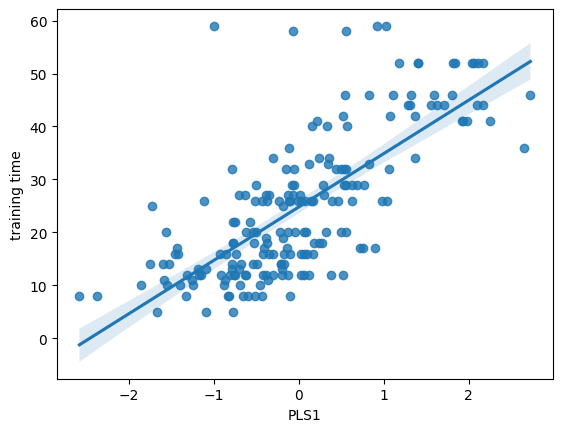

In [363]:
plot_component = 0
outlier = 50
data_plot = X_pls[np.where(X_pls[:, 0]<outlier)]
sns.regplot(x=np.array(data_plot[:, plot_component]).astype(float), y=y[np.where(X_pls[:, 0]<outlier)], 
            ci=95) 
plt.xlabel("PLS1")
plt.ylabel("training time")

res = stats.pearsonr(data_plot[:, plot_component], y[np.where(X_pls[:, 0]<outlier)])
print(res)


In [367]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, KFold

pls = PLSRegression(n_components=1)
pls.fit(X, y)

# In-sample R²
y_pred = pls.predict(X)
r2_in = r2_score(y, y_pred)

print("In-sample R2:", r2_in)

# Cross-validated R² (much better)
cv = KFold(n_splits=5, shuffle=True, random_state=0)
y_pred_cv = cross_val_predict(pls, X, y, cv=cv)
r2_cv = r2_score(y, y_pred_cv)

print("Cross-validated R2:", r2_cv)

In-sample R2: 0.547061815166727
Cross-validated R2: 0.3513879849824265


In [368]:
# Total variance in X
total_var = np.var(X, axis=0, ddof=1).sum()

# Variance of projected components
T = pls.x_scores_  # latent components

var_explained = []
for i in range(T.shape[1]):
    Xi = np.outer(T[:, i], pls.x_loadings_[:, i])
    var_explained.append(np.var(Xi, axis=0, ddof=1).sum() / total_var)

print("Variance explained in X per component:", var_explained)

Variance explained in X per component: [0.4668650515432054]


In [276]:
np.corrcoef(pls.x_scores_[:,0], y)[0,1]
np.corrcoef(pls.x_scores_[:,1], y)[0,1]

IndexError: index 1 is out of bounds for axis 1 with size 1

## Correlate with feature probability

In [129]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')

states_file['trial_type'] = states_file['correct'].astype(str) + states_file['choice'].astype(str)
states_file = states_file[['mouse_name', 'session', 'most_likely_states', 'trial_type', 'trial_id', 'broader_label',
                           'correct', 'reaction', 'response', 'elongation', 'choice', 'avg_wheel_vel', 'whisker_me', 'l_paw_x', 'r_paw_x']]

## Paw states

In [277]:
identifiable_mapping = {'000': 0.0,
        '100': 1.0,
        '200': 2.0,
        '300': 3.0,
        '400': 4.0,
        '500': 5.0,
        '600': 6.0,
        '700': 7.0,
        
        '010': 8.0,
        '110': 9.0,
        '210': 10.0,
        '310': 11.0,
        '410': 12.0,
        '510': 13.0,
        '610': 14.0,
        '710': 15.0,

        '001': 16.0,
        '101': 17.0,
        '201': 18.0,
        '301': 19.0, 
        '401': 20.0, 
        '501': 21.0, 
        '601': 22.0, 
        '701': 23.0, 

        '011': 24.0,
        '111': 25.0,
        '211': 26.0,
        '311': 27.0,
        '411': 28.0,
        '511': 29.0,
        '611': 30.0,
        '711': 31.0,
        'nan': np.nan
        }

inverted_mapping = {v: k for k, v in identifiable_mapping.items()}
inverted_func = np.vectorize(inverted_mapping.get)
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['0', '0', '0', '0', 
          '1', '1', '1', '1',
          '2', '2', '2', '2',
          '3', '3', '3', '3',
          '4', '4', '4', '4',
          '5', '5', '5', '5',
          '6', '6', '6', '6',
          '7', '7', '7', '7']

rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_func = np.vectorize(rename_labels.get)

In [278]:
states_file['paw_states'] = rename_func(inverted_func(states_file['most_likely_states']))

In [369]:
results_df = pd.DataFrame(X_pls[np.where(X_pls[:, 0]<outlier)])
results_df['mouse_name'] = np.array(syllables_df['mouse_name'])[np.where(X_pls[:, 0]<outlier)]
results_df['training_time'] = np.array(syllables_df['training_time'])[np.where(X_pls[:, 0]<outlier)]
results_df['session'] = np.array(session_syllables.reset_index()['session'])[np.where(X_pls[:, 0]<outlier)]
# results_df['mouse_cluster'] = np.array(session_syllables.reset_index()['session'])[np.where(X_pls[:, 0]<outlier)]


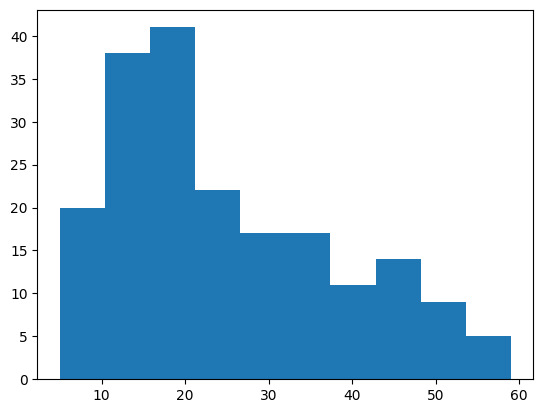

In [370]:
plt.hist(results_df['training_time'])
results_df['binned'] = pd.cut(results_df[0], 5)

In [324]:
data_path = prefix + 'representation_learning_variability/paper-individuality/clustering/'
filename = "mouse_PLS_5_bins"
import pickle
# pickle.dump(open(results_df, 'wb'), filename)
results_df.to_pickle(data_path+filename)  
# results_df.to_parquet(data_path+filename)  

In [343]:
results_df = results_df.merge(cluster_df[['mouse_name', 'mouse_cluster']], on='mouse_name')

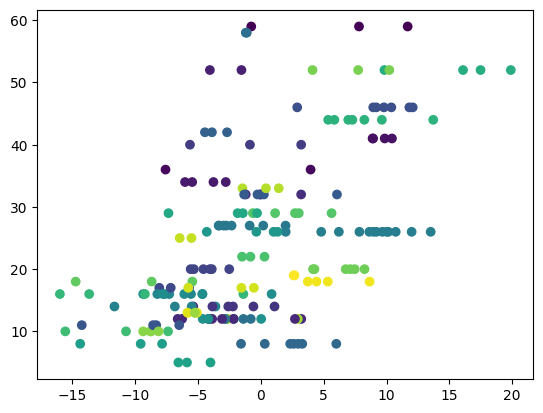

In [344]:
plt.scatter(results_df[0], results_df['training_time'], 
            c=pd.factorize(results_df['mouse_name'])[0], label= results_df['mouse_name'])


In [371]:
group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name', 'session']
# group_cols = ['mouse_name', 'broader_label']

# Count syllables per group
data = (
    states_file
    .groupby(group_cols + ['paw_states'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['paw_states']).reset_index().fillna(0)

lda_df = results_df.rename(columns={0:'PLS1', 1:'PLS2', 2:'PLS3', 3:'PLS4', 4:'PLS5', 5:'PLS6'})
lda_df = lda_df[['PLS1', 'PLS2', 'PLS3', 'PLS4', 'PLS5', 'PLS6', 'mouse_name']]
lda_df['session'] = np.array(session_syllables.reset_index()['session'])[np.where(X_pls[:, 0]<outlier)]

# lda_df = lda_df.loc[lda_df['LD1']>-15]

joint = data.merge(lda_df, on=['session', 'mouse_name'])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7845/3324069042.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[l, e].legend()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7845/3324069042.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[l, e].legend()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7845/3324069042.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[l, e].legend()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7845/3324069042.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start wi

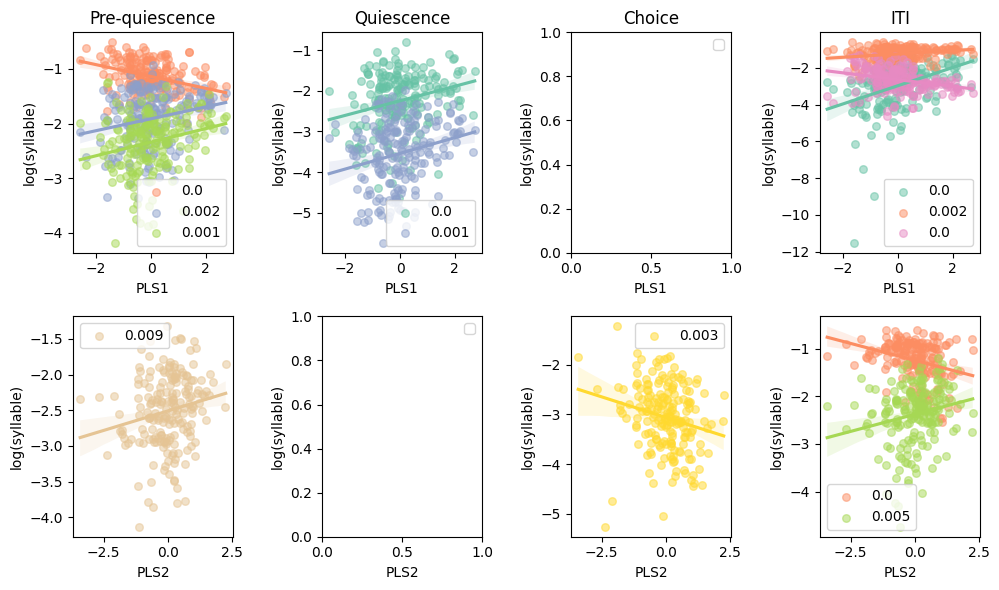

In [372]:
fig, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(10, 6))
palette = sns.color_palette('Set2', 8)
# for l, ld in enumerate(['LD1', 'LD2', 'LD3', 'LD4', 'LD5']):
for l, ld in enumerate(['PLS1', 'PLS2']):
    for e, epoch in enumerate(['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']):
        epoch_data = joint.loc[joint['broader_label']==epoch].dropna()
        for p, paw in enumerate(['0', '1', '2', '3', '4', '5', '6', '7']):
            paw_data = np.log(epoch_data[paw]+0.00001)
            # paw_data = np.sqrt(epoch_data[paw])
            ld_data = epoch_data[ld]
            res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(paw_data.astype(float)))
            if res[1] < 0.01:
                sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(paw_data.astype(float)), 
                            ax=axs[l, e], ci=95, color=palette[p], label=str(np.round(res[1], 3)), 
                            scatter_kws=dict(alpha=0.5, s=30, color=palette[p]))
            axs[l, e].set_xlabel(ld)
            axs[l, e].set_ylabel('log(syllable)')
            axs[l, e].legend()
        axs[0, e].set_title(epoch)

plt.tight_layout()

## Lick/whisk states

In [284]:
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick', 
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick']

rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_func = np.vectorize(rename_labels.get)


In [285]:
states_file['whisk_lick'] = rename_func(inverted_func(states_file['most_likely_states']))

In [163]:
group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name', 'session']
# group_cols = ['mouse_name', 'broader_label']

# Count syllables per group
data = (
    states_file
    .groupby(group_cols + ['whisk_lick'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['whisk_lick']).reset_index().fillna(0)

lda_df = results_df.rename(columns={0:'PLS1', 1:'PLS2', 2:'PLS3', 3:'PLS4', 4:'PLS5', 5:'PLS6'})
lda_df = lda_df[['PLS1', 'PLS2', 'PLS3', 'PLS4', 'PLS5', 'PLS6', 'mouse_name']]
lda_df['session'] = np.array(session_syllables.reset_index()['session'])[np.where(X_pls[:, 0]<outlier)]

# lda_df = lda_df.loc[lda_df['LD1']>-15]

joint = data.merge(lda_df, on=['session', 'mouse_name'])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7845/2513308671.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[l, e].legend()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7845/2513308671.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[l, e].legend()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7845/2513308671.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[l, e].legend()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7845/2513308671.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start wi

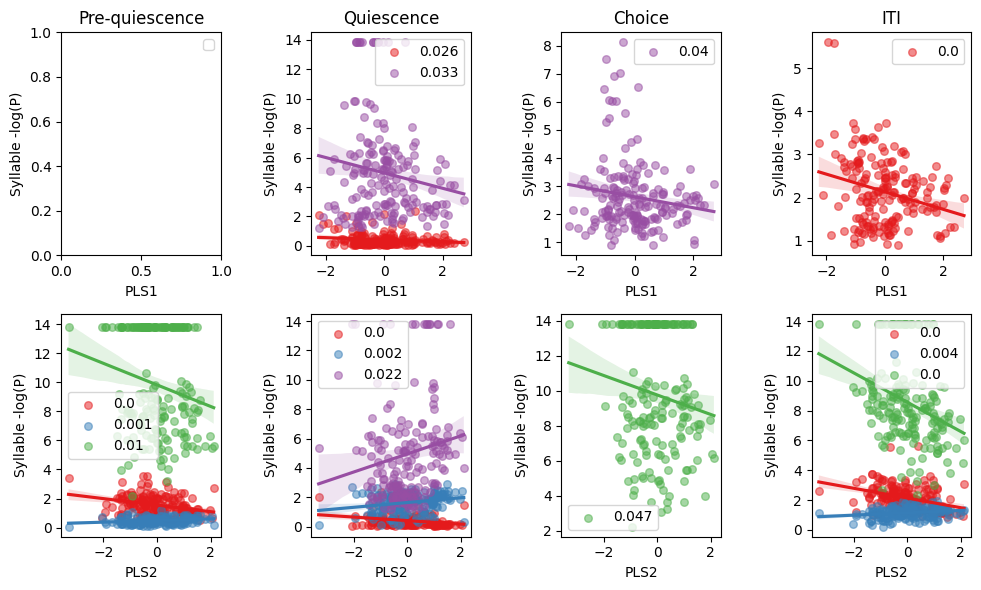

In [165]:
fig, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(10, 6))
palette = sns.color_palette('Set1', 4)
for l, ld in enumerate(['PLS1', 'PLS2']):
    for e, epoch in enumerate(['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']):
        epoch_data = joint.loc[joint['broader_label']==epoch].dropna()
        for p, paw in enumerate(['No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick']):
            paw_data = -np.log(epoch_data[paw]+0.000001)
            # paw_data = np.sqrt(epoch_data[paw])
            ld_data = epoch_data[ld]
            res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(paw_data.astype(float)))
            if res[1] < 0.05:
                sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(paw_data.astype(float)), 
                            ax=axs[l, e], ci=95, color=palette[p], label=str(np.round(res[1], 3)), 
                            scatter_kws=dict(alpha=0.5, s=30, color=palette[p]))
            # if l== 1:
            #     sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(paw_data.astype(float)), 
            #                 ax=axs[l, e], ci=95, color=palette[p], label=paw, 
            #                 scatter_kws=dict(alpha=0.5, s=30, color=palette[p]))
            axs[l, e].set_xlabel(ld)
            axs[l, e].set_ylabel('Syllable -log(P)')
            axs[l, e].legend()

        axs[0, e].set_title(epoch)

plt.tight_layout()

## Lick whisk states

In [373]:
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['No whisk', 'Whisk', 'No whisk', 'Whisk',  
          'No whisk', 'Whisk', 'No whisk', 'Whisk',  
          'No whisk', 'Whisk', 'No whisk', 'Whisk',    
          'No whisk', 'Whisk', 'No whisk', 'Whisk',    
          'No whisk', 'Whisk', 'No whisk', 'Whisk',   
          'No whisk', 'Whisk', 'No whisk', 'Whisk',    
          'No whisk', 'Whisk', 'No whisk', 'Whisk',  
          'No whisk', 'Whisk', 'No whisk', 'Whisk',  ]

rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_func = np.vectorize(rename_labels.get)


In [374]:
states_file['whisk'] = rename_func(inverted_func(states_file['most_likely_states']))

In [375]:
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['No lick', 'No lick', 'Lick', 'Lick',
          'No lick', 'No lick', 'Lick', 'Lick',
          'No lick', 'No lick', 'Lick', 'Lick',   
          'No lick', 'No lick', 'Lick', 'Lick',   
          'No lick', 'No lick', 'Lick', 'Lick',  
          'No lick', 'No lick', 'Lick', 'Lick',    
          'No lick', 'No lick', 'Lick', 'Lick',  
          'No lick', 'No lick', 'Lick', 'Lick',]

rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_lick = np.vectorize(rename_labels.get)
states_file['lick'] = rename_lick(inverted_func(states_file['most_likely_states']))

In [376]:
group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name', 'broader_label']

# Count syllables per group
data = (
    states_file
    .groupby(group_cols + ['whisk'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['whisk']).reset_index().fillna(0)

In [377]:
lda_df = results_df.rename(columns={0:'PLS1', 1:'PLS2', 2:'PLS3', 3:'PLS4', 4:'PLS5', 5:'PLS6'})
lda_df = lda_df[['PLS1', 'PLS2', 'PLS3', 'PLS4', 'PLS5', 'PLS6', 'mouse_name']]
lda_df['session'] = np.array(session_syllables.reset_index()['session'])[np.where(X_pls[:, 0]<outlier)]

joint = data.merge(lda_df, on=['session', 'mouse_name'])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7845/3598516151.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[l, e].legend()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7845/3598516151.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[l, e].legend()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7845/3598516151.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[l, e].legend()
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7845/3598516151.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start wi

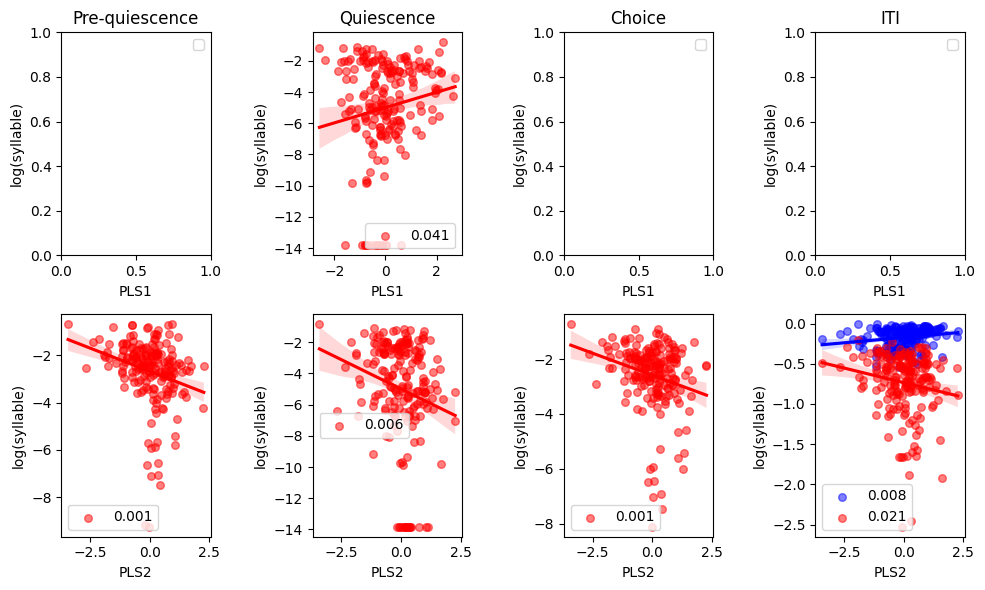

In [378]:
fig, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(10, 6))
palette = sns.color_palette('Set1', 4)
for l, ld in enumerate(['PLS1', 'PLS2']):
    for e, epoch in enumerate(['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']):
        epoch_data = joint.loc[joint['broader_label']==epoch].dropna()
        for p, paw in enumerate(['Whisk']):
            paw_data = np.log(epoch_data[paw]+0.000001)
            # paw_data = np.sqrt(epoch_data[paw])
            ld_data = epoch_data[ld]
            res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(paw_data.astype(float)))
            if res[1] < 0.05:
                sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(paw_data.astype(float)), 
                            ax=axs[l, e], ci=95, color='blue', label=str(np.round(res[1], 3)), 
                            scatter_kws=dict(alpha=0.5, s=30, color='blue'))
            axs[l, e].set_xlabel(ld)
            axs[l, e].set_ylabel('log(syllable)')
            axs[l, e].legend()

        axs[0, e].set_title(epoch)


group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name', 'broader_label']
# Count syllables per group
data = (
    states_file
    .groupby(group_cols + ['lick'])
    .size()
    .reset_index(name='count'))
# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))
group_cols = ['mouse_name', 'session', 'broader_label']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['lick']).reset_index().fillna(0)


lda_df = results_df.rename(columns={0:'PLS1', 1:'PLS2', 2:'PLS3', 3:'PLS4', 4:'PLS5', 5:'PLS6'})
lda_df = lda_df[['PLS1', 'PLS2', 'PLS3', 'PLS4', 'PLS5', 'PLS6', 'mouse_name']]
lda_df['session'] = np.array(session_syllables.reset_index()['session'])[np.where(X_pls[:, 0]<outlier)]

joint = data.merge(lda_df, on=['session', 'mouse_name'])

for l, ld in enumerate(['PLS1', 'PLS2']):
    for e, epoch in enumerate(['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']):
        epoch_data = joint.loc[joint['broader_label']==epoch].dropna()
        for p, paw in enumerate(['Lick']):
            paw_data = np.log(epoch_data[paw]+0.000001)
            # paw_data = np.sqrt(epoch_data[paw])
            ld_data = epoch_data[ld]
            res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(paw_data.astype(float)))
            if res[1] < 0.05:
                sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(paw_data.astype(float)), 
                            ax=axs[l, e], ci=95, color='red', label=str(np.round(res[1], 3)), 
                            scatter_kws=dict(alpha=0.5, s=30, color='red'))
            axs[l, e].set_xlabel(ld)
            axs[l, e].set_ylabel('log(syllable)')
            axs[l, e].legend()

        axs[0, e].set_title(epoch)
plt.tight_layout()

# Trial-level descriptors

In [226]:
lda_df = clustered.rename(columns={0:'LD1', 1:'LD2', 2:'LD3', 3:'LD4', 4:'LD5', 5:'LD6'})
lda_df = lda_df[['LD1', 'LD2', 'LD3', 'LD4', 'LD5', 'LD6', 'mouse_name', 'lab',
          'lab_number', 'litter_id', 'litter_number', 'mouse_cluster']]
lda_df['session'] = np.array(session_syllables.reset_index()['session'])


lda_df = lda_df.loc[lda_df['LD1']>-15]


joint = data.merge(lda_df, on=['session', 'mouse_name'])

In [227]:
states_file['binary_choice'] = states_file['choice']
states_file.loc[states_file['choice']=='left', 'binary_choice'] = 0.0
states_file.loc[states_file['choice']=='right', 'binary_choice'] = 1.0

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/76687812.py:23: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/76687812.py:23: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/76687812.py:23: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/76687812.py:23: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no

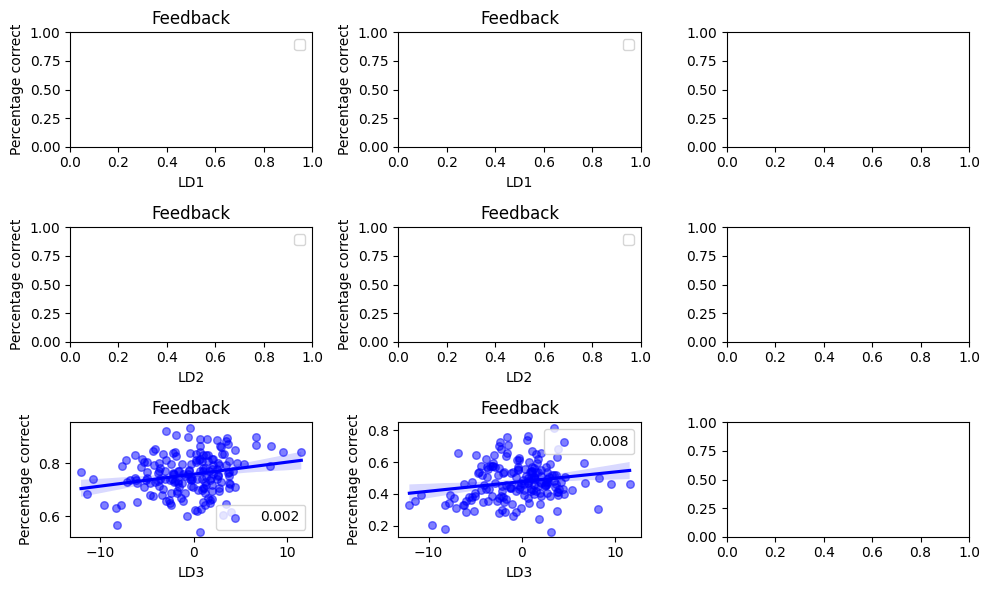

In [280]:
vars_interest = ['correct', 'binary_choice'] #, 'reaction', 'elongation']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(10, 6))
palette = sns.color_palette('Set1', 4)
for l, ld in enumerate(['LD1', 'LD2', 'LD3']):
    for v, var in enumerate(vars_interest):
        states_file[var] = states_file[var].astype(float)
        group_cols = ['mouse_name', 'session']
        # Mean per group
        data = (states_file.groupby(group_cols)[var].mean().reset_index())
        joint = data.merge(lda_df, on=['session', 'mouse_name'])
        
        var_data = joint[var]
        ld_data = joint[ld]
        res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(var_data.astype(float)))
        if res[1] < 0.05:
            sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(var_data.astype(float)), 
                        ax=axs[l, v], ci=95, color='blue', label=str(np.round(res[1], 3)), 
                        scatter_kws=dict(alpha=0.5, s=30, color='blue'))

        axs[l, v].set_xlabel(ld)
        axs[l, v].set_ylabel('Percentage correct')
        axs[l, v].legend()
        axs[l, v].set_title('Feedback')

plt.tight_layout()

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2375032643.py:25: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2375032643.py:25: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2375032643.py:25: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2375032643.py:25: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called

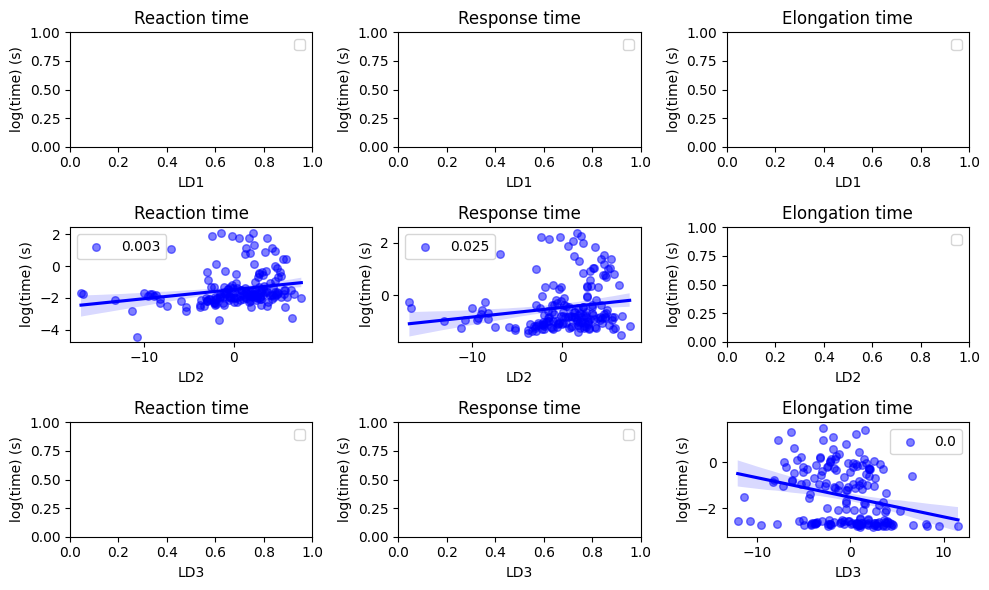

In [229]:
vars_interest = ['reaction', 'response', 'elongation']
titles = ['Reaction time', 'Response time', 'Elongation time']
fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(10, 6))
palette = sns.color_palette('Set1', 4)
for l, ld in enumerate(['LD1', 'LD2', 'LD3']):
    for v, var in enumerate(vars_interest):
        states_file[var] = states_file[var].astype(float)
        group_cols = ['mouse_name', 'session']
        # Mean per group
        data = (states_file.groupby(group_cols)[var].median().reset_index())
        joint = data.merge(lda_df, on=['session', 'mouse_name'])
        
        var_data = np.log(joint[var])
        # var_data = np.sqrt(joint[var])
        # var_data = joint[var]
        ld_data = joint[ld]
        res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(var_data.astype(float)))
        if res[1] < 0.05:
            sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(var_data.astype(float)), 
                        ax=axs[l, v], ci=95, color='blue', label=str(np.round(res[1], 3)), 
                        scatter_kws=dict(alpha=0.5, s=30, color='blue'))

        axs[l, v].set_xlabel(ld)
        axs[l, v].set_ylabel('log(time) (s)')
        axs[l, v].legend()
        axs[l, v].set_title(titles[v])

plt.tight_layout()

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2631811224.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2631811224.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2631811224.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2631811224.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called

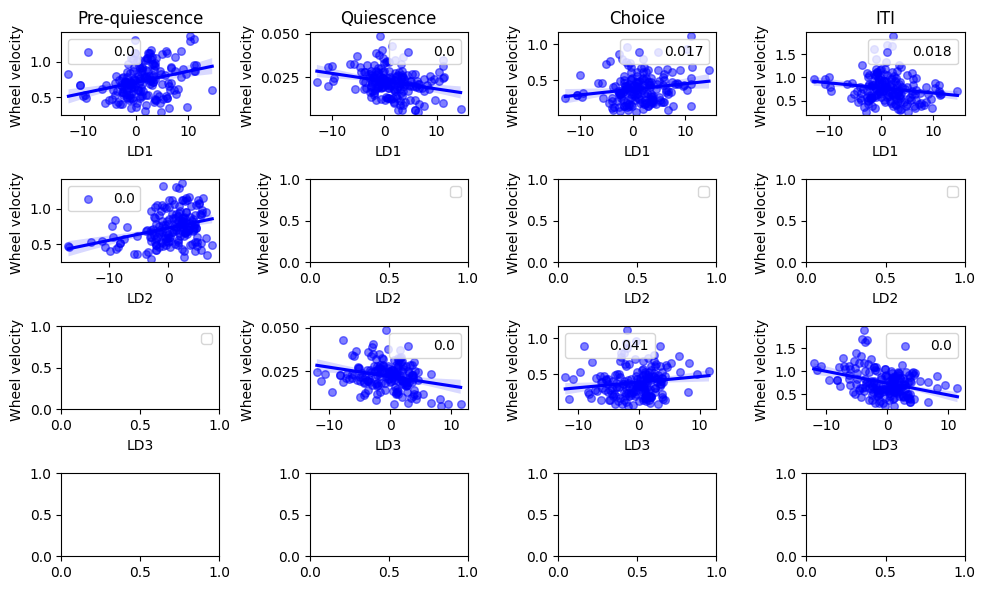

In [ ]:
var = 'abs_wheel_vel'
states_file['abs_wheel_vel'] = np.abs(states_file['avg_wheel_vel'])

fig, axs = plt.subplots(3, 4, sharex=False, sharey=False, figsize=(10, 6))
palette = sns.color_palette('Set1', 4)
for l, ld in enumerate(['LD1', 'LD2', 'LD3']):
    for e, epoch in enumerate(['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']):
        colors = ['blue', 'red']
        states_file[var] = states_file[var].astype(float)
        group_cols = ['mouse_name', 'session', 'broader_label']
        # Mean per group
        data = (states_file.groupby(group_cols)[var].mean().reset_index())
        joint = data.merge(lda_df, on=['session', 'mouse_name'])

        epoch_data = joint.loc[joint['broader_label']==epoch].dropna()

        var_data = -np.log(epoch_data[var])
        var_data = epoch_data[var]
        # paw_data = np.sqrt(epoch_data[paw])
        ld_data = epoch_data[ld]
        res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(var_data.astype(float)))
        if res[1] < 0.05:
            sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(var_data.astype(float)), 
                        ax=axs[l, e], ci=95, color=colors[0], label=str(np.round(res[1], 3)), 
                        scatter_kws=dict(alpha=0.5, s=30, color=colors[0]))

        axs[l, e].set_xlabel(ld)
        axs[l, e].set_ylabel('Wheel velocity ')
        axs[l, e].legend()

        axs[0, e].set_title(epoch)

plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


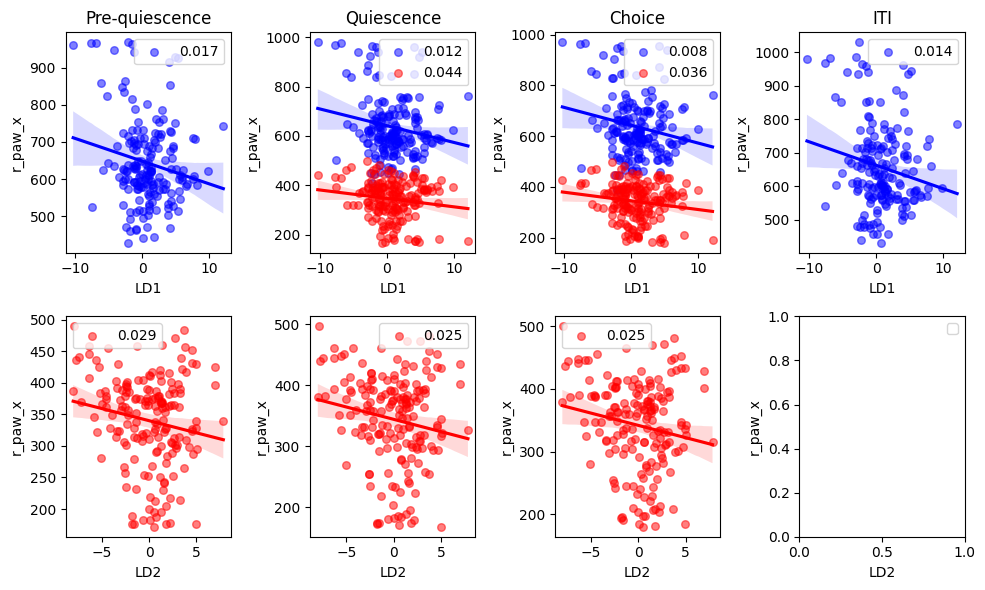

In [ ]:
var = 'abs_wheel_vel'
states_file['abs_wheel_vel'] = np.abs(states_file['avg_wheel_vel'])

fig, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(10, 6))
palette = sns.color_palette('Set1', 4)
for l, ld in enumerate(['LD1', 'LD2']):
    for e, epoch in enumerate(['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']):
        for v, var in enumerate(['l_paw_x', 'r_paw_x']):
            colors = ['blue', 'red']
            states_file[var] = states_file[var].astype(float)
            group_cols = ['mouse_name', 'session', 'broader_label']
            # Mean per group
            data = (states_file.groupby(group_cols)[var].mean().reset_index())
            joint = data.merge(lda_df, on=['session', 'mouse_name'])

            epoch_data = joint.loc[joint['broader_label']==epoch].dropna()

            # var_data = -np.log(epoch_data[var])
            var_data = epoch_data[var]
            # paw_data = np.sqrt(epoch_data[paw])
            ld_data = epoch_data[ld]
            res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(var_data.astype(float)))
            if res[1] < 0.05:
                sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(var_data.astype(float)), 
                            ax=axs[l, e], ci=95, color=colors[v], label=str(np.round(res[1], 3)), 
                            scatter_kws=dict(alpha=0.5, s=30, color=colors[v]))

            axs[l, e].set_xlabel(ld)
            axs[l, e].set_ylabel(var)
            axs[l, e].legend()

            axs[0, e].set_title(epoch)

plt.tight_layout()

# Plot correlations per epoch and state

In [ ]:
use_lda = clustered.copy()
use_lda['session'] = np.array(session_syllables.reset_index()['session'])
use_lda = use_lda.sort_values(by=['session'])


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_26183/2420400624.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['syllable'] = rename_func(use_data['syllable'])
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anacond

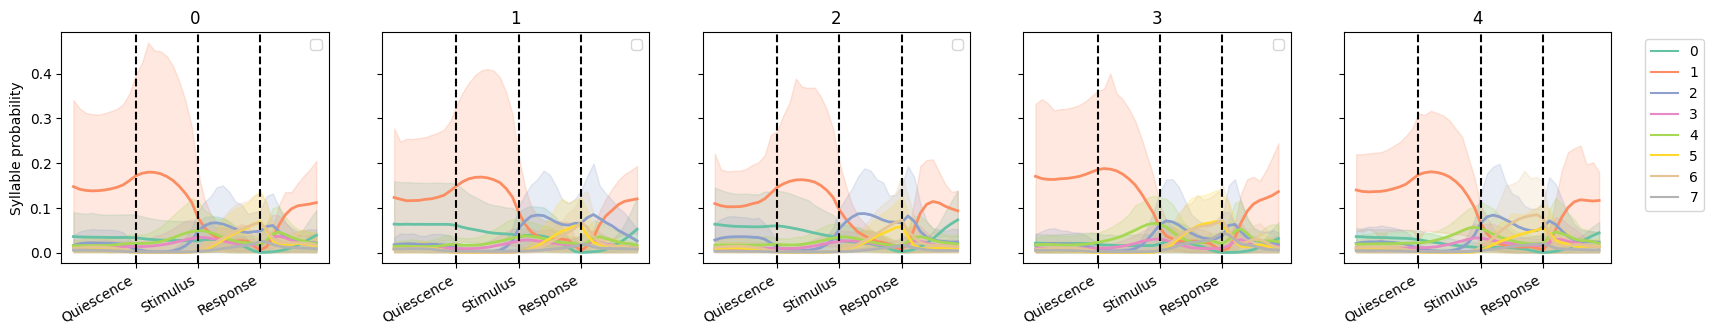

In [ ]:
syllable_labels = ['000', '100', '200', '300', '400', '500', '600', '700',
                   '010', '110', '210', '310', '410', '510', '610', '710',
                   '001', '101', '201', '301', '401', '501', '601', '701',
                   '011', '111', '211', '311', '411', '511', '611', '711']

palette_7 = create_grouped_gradient_palette(n_groups=8, shades_per_group=1, base_palette='Set2')
palette_7_list = [palette_7(i) for i in range(palette_7.N)]  # Extract colors properly


fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20, 3))

for c, cluster in enumerate(np.unique(clusters)):
    use_data = reshaped_probs.loc[reshaped_probs['cluster']==cluster]
    use_data['syllable'] = rename_func(use_data['syllable'])
    use_data = use_data.copy()
    sns.lineplot(x='timestep', y='prob', hue='syllable', data=use_data, 
                ax=axs[c], palette='Set2',  linewidth=2)  #  legend=labels[c]  style=var_interest,

    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')
    axs[c].set_ylabel('Syllable probability')
    axs[c].set_xlabel('')
    # axs[c].set_ylim([0, 0.85])
    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[c].legend('')
    axs[c].set_title(cluster)
axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))

In [ ]:
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick', 
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick']

rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_func = np.vectorize(rename_labels.get)

# Syllable corr per timestep

In [168]:
identifiable_mapping = {'000': 0.0,
        '100': 1.0,
        '200': 2.0,
        '300': 3.0,
        '400': 4.0,
        '500': 5.0,
        '600': 6.0,
        '700': 7.0,
        
        '010': 8.0,
        '110': 9.0,
        '210': 10.0,
        '310': 11.0,
        '410': 12.0,
        '510': 13.0,
        '610': 14.0,
        '710': 15.0,

        '001': 16.0,
        '101': 17.0,
        '201': 18.0,
        '301': 19.0, 
        '401': 20.0, 
        '501': 21.0, 
        '601': 22.0, 
        '701': 23.0, 

        '011': 24.0,
        '111': 25.0,
        '211': 26.0,
        '311': 27.0,
        '411': 28.0,
        '511': 29.0,
        '611': 30.0,
        '711': 31.0,
        'nan': np.nan
        }

inverted_mapping = {v: k for k, v in identifiable_mapping.items()}
inverted_func = np.vectorize(inverted_mapping.get)
identifiable_func = np.vectorize(identifiable_mapping.get)
    
from matplotlib.colors import ListedColormap, to_rgb, to_hex

def create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set1'):
    # Pick n_groups distinct colors from base palette
    base_colors = sns.color_palette(base_palette, n_colors=n_groups)
    
    # Function to generate shades for a given color
    def generate_shades(color, n_shades):
        color_rgb = np.array(to_rgb(color))
        # Create shades by interpolating towards white (lighter) or black (darker)
        factors = np.linspace(0.4, 1.0, n_shades)  # You can adjust range for more/less contrast
        return [to_hex(color_rgb * factor + (1 - factor)) for factor in factors]
    
    # Build full palette
    full_palette = []
    for color in base_colors:
        shades = generate_shades(color, shades_per_group)
        full_palette.extend(shades)
    
    return ListedColormap(full_palette)

palette_16 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set2')

identifiable_mapping = {'000': 0.0,
        '100': 4.0,
        '200': 8.0,
        '300': 12.0,
        '400': 16.0,
        '500': 20.0,
        '600': 24.0,
        '700': 28.0,
        
        '010': 1.0,
        '110': 5.0,
        '210': 9.0,
        '310': 13.0,
        '410': 17.0,
        '510': 21.0,
        '610': 25.0,
        '710': 29.0,

        '001': 2.0,
        '101': 6.0,
        '201': 10.0,
        '301': 14.0, 
        '401': 18.0, 
        '501': 22.0, 
        '601': 26.0, 
        '701': 30.0, 

        '011': 3.0,
        '111': 7.0,
        '211': 11.0,
        '311': 15.0,
        '411': 19.0,
        '511': 23.0,
        '611': 27.0,
        '711': 31.0,
        'nan': np.nan
        }

# inverted_mapping = {v: k for k, v in identifiable_mapping.items()}
inverted_func = np.vectorize(inverted_mapping.get)
identifiable_func = np.vectorize(identifiable_mapping.get)

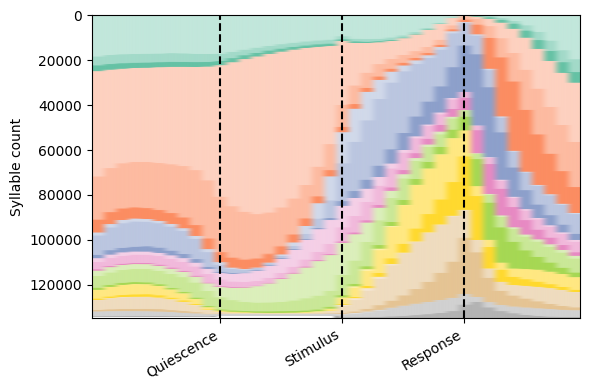

In [169]:
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(6, 4))

epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

mouse_data = all_sequences.copy()
bound = int(np.shape(mouse_data)[0]/4)
mouse_seq = np.ones((bound, 40)) * np.nan
all_epochs = []
for e, epoch in enumerate(epoch_to_analyse):
    epoch_data = np.vstack(mouse_data.loc[mouse_data['broader_label']==epoch, 'binned_sequence'].values)[:bound, :]
    epoch_data = inverted_func(epoch_data)
    # epoch_data = rename_func(epoch_data)
    epoch_data = identifiable_func(epoch_data)
    mouse_seq[:np.shape(epoch_data)[0], 10*e:10*e+10] = epoch_data[:np.shape(epoch_data)[0], :]
    # if e == 0:
    #     all_epochs = epoch_data[:bound-10, :]
    # else:
    #     all_epochs = np.concatenate([all_epochs, epoch_data[:bound-10, :]], axis=1)
# sorted = all_epochs[np.argsort([ordered_dict[row[0]] for row in all_epochs])]
axs.imshow(np.sort(mouse_seq, axis=0), aspect='auto', cmap=palette_16, interpolation=None, alpha=1)
axs.axvline(x=10, color='k', linestyle='--')
axs.axvline(x=20, color='k', linestyle='--')
axs.axvline(x=30, color='k', linestyle='--')
axs.set_ylabel('Syllable count')
axs.set_xlabel('')
axs.set_title('')
axs.set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
plt.tight_layout()
# axs[m].set_yticks('')
# plt.show()

## Per syllable x epoch 
- no trial type
- for clustering of mice

In [219]:
n_ld = 6
n_syllables = 32*4


In [237]:
group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name', 'broader_label']

# Count syllables per group
data = (
    syllable_df
    .groupby(group_cols + ['most_likely_states'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

group_cols = ['mouse_name', 'session']
# group_cols = ['mouse_name']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['most_likely_states', 'broader_label']).reset_index().fillna(0)



In [238]:
df = pd.DataFrame(np.array(data.drop(columns=['mouse_name', 'session'])))
df['mouse_name'] = data['mouse_name']
df['session'] = data['session']

/tmp/ipykernel_9458/2165378409.py:1: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [239]:
df = pd.DataFrame(np.array(data.drop(columns='mouse_name')))
df['mouse_name'] = data['mouse_name']

avg_lda = clustered.groupby(['mouse_name', 'lab', 'lab_number', 'litter_id', 'litter_number', 'mouse_cluster'])[np.arange(0, n_ld, 1)].mean().reset_index()
# avg_lda = avg_lda.rename(columns={0:'LD1', 1:'LD2', 2:'LD3', 3:'LD4', 4:'LD5', 5:'LD6'})
use_mice = avg_lda.mouse_name.unique()
df = df.loc[df['mouse_name'].isin(use_mice)]


/tmp/ipykernel_9458/2358175265.py:1: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [240]:
n_ld = 6
C = np.zeros((n_ld, n_syllables))
for k in range(n_ld):
    C[k] = [
        stats.pearsonr(df[s], avg_lda[k])[0]
        for s in range(n_syllables)
    ]

sns.heatmap(C, center=0, cmap='coolwarm')
plt.ylabel('LDA component')
plt.xlabel('Syllable')


ValueError: `x` and `y` must have the same length along `axis`.

In [234]:
# avg_lda = clustered.groupby(['mouse_name', 'lab', 'lab_number', 'litter_id', 'litter_number', 'mouse_cluster'])[np.arange(0, n_ld, 1)].mean().reset_index()
use_lda = clustered.copy()
use_lda['session'] = np.array(session_syllables.reset_index()['session'])
use_lda = use_lda.sort_values(by=['session'])

use_mice = use_lda.mouse_name.unique()
df = df.loc[df['mouse_name'].isin(use_mice)]
df = df.sort_values(by=['session'])


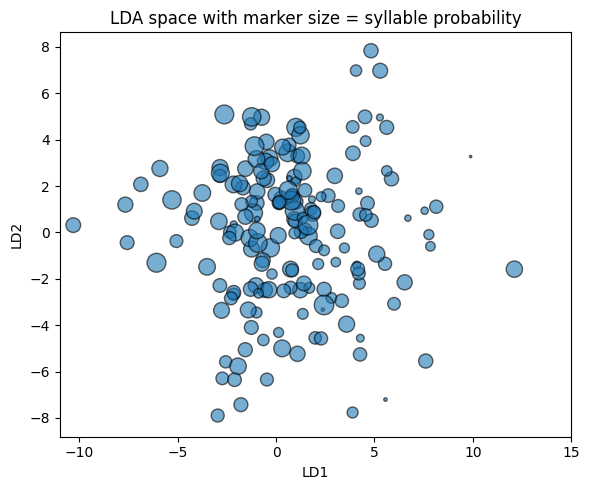

In [223]:

# rescale probabilities → marker sizes
p = np.array(df[0])
sizes = 0 + 200 * (p - p.min()) / (p.max() - p.min())

plt.figure(figsize=(6,5))

plt.scatter(
    use_lda[0],
    use_lda[1],
    s=sizes,
    alpha=0.6,
    edgecolor='k'
)

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('LDA space with marker size = syllable probability')
plt.xlim([-11, 15])
plt.tight_layout()
plt.show()


In [114]:
from scipy import stats

IndexError: index 3 is out of bounds for axis 0 with size 3

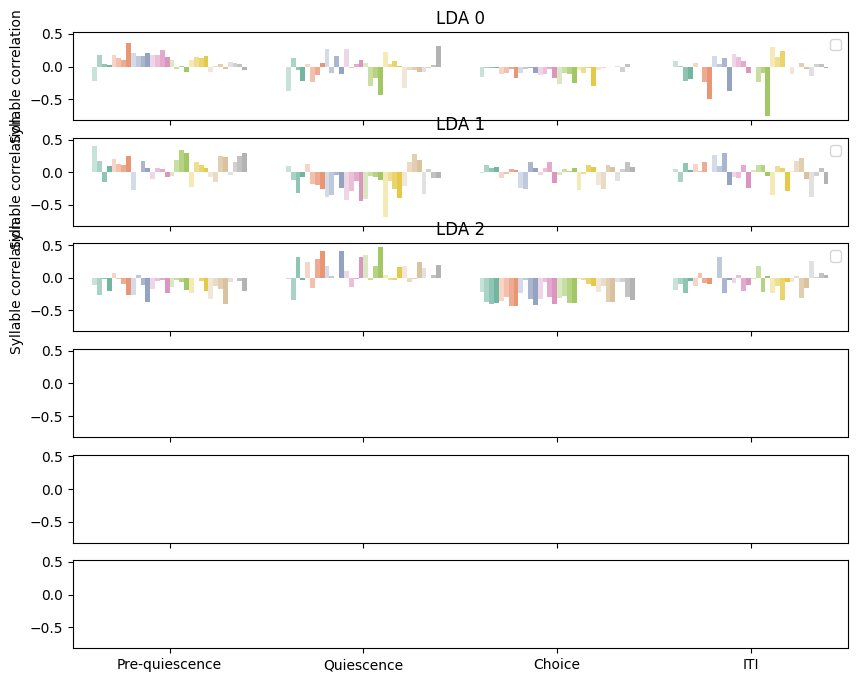

In [212]:
palette_16 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set2')

palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly

fig, axs = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(10, 8))

for l in range(6):
    C_df = pd.DataFrame(C[l, :])
    C_df['syllable_name'] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                                '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                                '111', '211', '311', '411', '511',  '611',  '711']*4
    C_df['epoch'] = np.concatenate([np.zeros(32), np.zeros(32)+1, np.zeros(32)+2, np.zeros(32)+3])

    sns.barplot(x='epoch', y=use_lda, hue='syllable_name', data=C_df, palette=palette_16_list, ax=axs[l])
    axs[l].set_ylabel('Syllable correlation')
    axs[l].set_xlabel('')
    axs[l].set_title('LDA '+str(l))
    axs[l].set_xticks([0, 1, 2, 3], ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI'], rotation=30, ha='right')
    axs[l].legend('')
axs[2].legend(loc='upper left', bbox_to_anchor=(1.1, 3.5))

plt.tight_layout()

/tmp/ipykernel_9458/3890619626.py:40: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



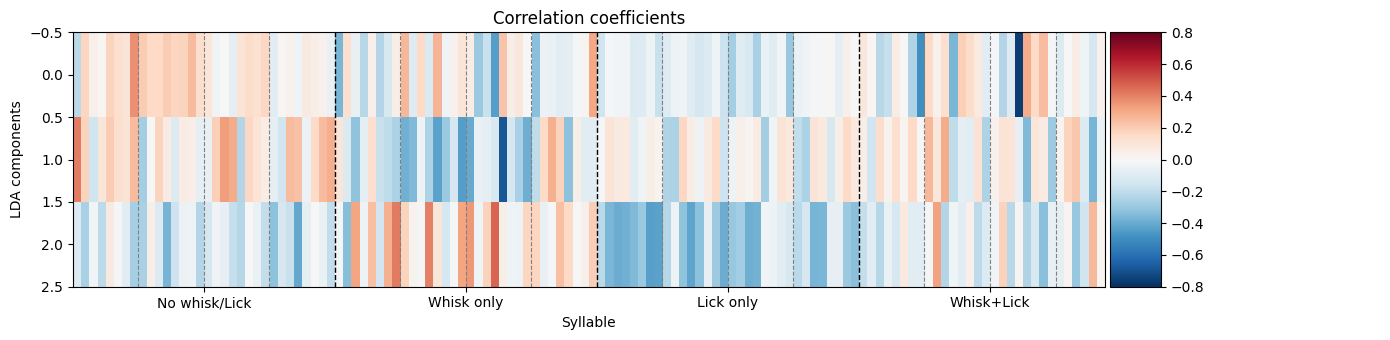

In [121]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

syllable_labels = ['000', '100', '200', '300', '400', '500', '600', '700',
                   '010', '110', '210', '310', '410', '510', '610', '710',
                   '001', '101', '201', '301', '401', '501', '601', '701',
                   '011', '111', '211', '311', '411', '511', '611', '711']
# plot weights for phase and individual identity
fig, ax = plt.subplots()
fig.set_size_inches(14,3.5)

plt_coefs = np.array(C)[:, :-2].astype(float)
plt.imshow(plt_coefs, cmap='RdBu_r', vmin=-.8, vmax=.8, aspect='auto')
plt.title('Correlation coefficients')
ax = plt.gca()
# plt.axhline(np.where(np.diff(mouse_coefs['mouse_cluster'])==1)[0][4] - 0.5+1, c='k', ls='--', lw=1)
plt.axvline(32-0.5, c='k', ls='--', lw=1)
plt.axvline(32*2 - 0.5, c='k', ls='--', lw=1)
plt.axvline(32*3 - 0.5, c='k', ls='--', lw=1)

plt.axvline(8-0.5, c='grey', ls='--', lw=.8)
plt.axvline(8*2 - 0.5, c='grey', ls='--', lw=.8)
plt.axvline(8*3 - 0.5, c='grey', ls='--', lw=.8)
plt.axvline(32+8-0.5, c='grey', ls='--', lw=.8)
plt.axvline(32+8*2 - 0.5, c='grey', ls='--', lw=.8)
plt.axvline(32+8*3 - 0.5, c='grey', ls='--', lw=.8)
plt.axvline((32*2)+8-0.5, c='grey', ls='--', lw=.8)
plt.axvline((32*2)+8*2 - 0.5, c='grey', ls='--', lw=.8)
plt.axvline((32*2)+8*3 - 0.5, c='grey', ls='--', lw=.8)
plt.axvline((32*3)+8-0.5, c='grey', ls='--', lw=.8)
plt.axvline((32*3)+8*2 - 0.5, c='grey', ls='--', lw=.8)
plt.axvline((32*3)+8*3 - 0.5, c='grey', ls='--', lw=.8)
# plt.xlim(-1.5, mouse_coefs.shape[1] - 0.5)
# plt.xticks(np.arange(0, 32*4, 1), syllable_labels*4)
plt.xticks(np.arange(16, 16*8, 32)-0.5, ['No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick'])

# plt.xticks(np.arange(8, 47, 5), np.arange(0, 39, 5))
# plt.yticks(np.arange(0, len(mouse_coefs), 1), mouse_coefs['mouse_name'])
plt.xlabel('Syllable')
plt.ylabel('LDA components')
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.25, 1))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.tight_layout()

In [79]:
mouse_means = avg_lda.merge(df, on='mouse_name')
syllable_cols = np.arange(0, n_syllables, 1)
mouse_corrs = mouse_means[syllable_cols].corrwith(mouse_means[['LD1']])

In [31]:
data = 32*4

most_likely_states     mouse_name                               session  \
broader_label                                                             
0                     CSH_ZAD_019  49e0ab27-827a-4c91-bcaa-97eea27a1b8d   
1                     CSH_ZAD_019  5adab0b7-dfd0-467d-b09d-43cb7ca5d59c   
2                     CSH_ZAD_019  7f6b86f9-879a-4ea2-8531-294a221af5d0   
3                     CSH_ZAD_019  edd22318-216c-44ff-bc24-49ce8be78374   
4                     CSH_ZAD_026  15763234-d21e-491f-a01b-1238eb96d389   
..                            ...                                   ...   
213                 ibl_witten_29  86b6ba67-c1db-4333-add0-f8105ea6e363   
214                 ibl_witten_29  af55d16f-0e31-4073-bdb5-26da54914aa2   
215                 ibl_witten_29  d2832a38-27f6-452d-91d6-af72d794136c   
216                 ibl_witten_29  e9fc0a2d-c69d-44d1-9fa3-314782387cae   
217                 ibl_witten_32  08102cfc-a040-4bcf-b63c-faa0f4914a6f   

most_likely_states       0.0                                           1.0  \
broader_label         Choice       ITI Pre-quiescence Quiescence    Choice   
0                   0.339149  0.120699       0.026358   0.129680  0.140835   
1                   0.369138  0.079765       0.022117   0.094783  0.141354   
2                   0.081512  0.026050       0.010976   0.021330  0.022520   
3                   0.198104  0.119824       0.020911   0.120278  0.168218   
4                   0.568998  0.032781       0.067390   0.162735  0.185915   
..                       ...       ...            ...        ...       ...   
213                 0.305885  0.006750       0.024470   0.194582  0.338245   
214                 0.442594  0.008364       0.110699   0.259749  0.247803   
215                 0.300465  0.031153       0.016331   0.114108  0.185275   
216                 0.597074  0.017285       0.012846   0.179157  0.151445   
217                 0.518088  0.004905       0.032702   0.126036  0.225994   

most_likely_states                                      ...           29.0  \
broader_label            ITI Pre-quiescence Quiescence  ... Pre-quiescence   
0                   0.163326       0.137204   0.501808  ...       0.020407   
1                   0.168883       0.142334   0.436730  ...       0.011516   
2                   0.021784       0.023636   0.053325  ...       0.014904   
3                   0.154162       0.115544   0.457545  ...       0.033567   
4                   0.189763       0.372450   0.592664  ...       0.023625   
..                       ...            ...        ...  ...            ...   
213                 0.020593       0.151875   0.654395  ...       0.009765   
214                 0.014103       0.251933   0.631072  ...       0.014326   
215                 0.047783       0.084557   0.534725  ...       0.007955   
216                 0.039398       0.086084   0.612262  ...       0.001900   
217                 0.047965       0.392077   0.414648  ...       0.000000   

most_likely_states                 30.0                                      \
broader_label      Quiescence    Choice       ITI Pre-quiescence Quiescence   
0                    0.000183  0.028764  0.056517       0.036108   0.000365   
1                    0.000388  0.028339  0.073717       0.024861   0.000000   
2                    0.000739  0.027477  0.048216       0.030018   0.000675   
3                    0.000402  0.030655  0.040884       0.029857   0.000438   
4                    0.000000  0.005424  0.067737       0.026853   0.000000   
..                        ...       ...       ...            ...        ...   
213                  0.000787  0.003801  0.088912       0.006433   0.000337   
214                  0.000000  0.000732  0.120891       0.027127   0.000000   
215                  0.000048  0.007207  0.017668       0.002862   0.000000   
216                  0.000000  0.002417  0.056607       0.006616   0.000000   
217                  0.000000  0.001263  0.043